Function that uses Gemini to classify user questions

In [121]:
!pip install --upgrade google-genai

In [122]:
from google import genai
from google.genai import types
import base64
import os

user_input = "If I make 2,000,000 a year, what will I pay in Federal taxes"

def generateClassification(user_input):
  client = genai.Client(
      vertexai=True,
      api_key=os.environ.get("GOOGLE_CLOUD_API_KEY"),
  )

  si_text1 = """You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related.

You will respond only with the classification category."""

  model = "gemini-2.5-flash"
  contents = [
    types.Content(
      role="user",
      parts=[types.Part.from_text(text=user_input)
      ]
    )
  ]
  tools = [
    types.Tool(google_search=types.GoogleSearch()),
  ]

  generate_content_config = types.GenerateContentConfig(
    temperature = 1,
    top_p = 1,
    max_output_tokens = 65535,
    safety_settings = [types.SafetySetting(
      category="HARM_CATEGORY_HATE_SPEECH",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_DANGEROUS_CONTENT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_SEXUALLY_EXPLICIT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_HARASSMENT",
      threshold="OFF"
    )],
    tools = tools,
    system_instruction=[types.Part.from_text(text=si_text1)],
    thinking_config=types.ThinkingConfig(
      thinking_budget=-1,
    ),
  )
  output = ""
  for chunk in client.models.generate_content_stream(
    model = model,
    contents = contents,
    config = generate_content_config,
    ):
    if not chunk.candidates or not chunk.candidates[0].content or not chunk.candidates[0].content.parts:
        continue
    output=output+(chunk.text)
  return output
generateClassification(user_input)


'Tax Related'

In [123]:
user_input = "There will be a snow day tomorrow and sports are canceled as well."

def generateAnnouncement(user_input):
  client = genai.Client(
      vertexai=True,
      api_key=os.environ.get("GOOGLE_CLOUD_API_KEY"),
  )

  si_text1 = """You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.
  You will be informative and professional.

  Keep the posts under 100 characters"""

  model = "gemini-2.5-flash"
  contents = [
    types.Content(
      role="user",
      parts=[types.Part.from_text(text=user_input)
      ]
    )
  ]
  tools = [
    types.Tool(google_search=types.GoogleSearch()),
  ]

  generate_content_config = types.GenerateContentConfig(
    temperature = 1,
    top_p = 1,
    max_output_tokens = 65535,
    safety_settings = [types.SafetySetting(
      category="HARM_CATEGORY_HATE_SPEECH",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_DANGEROUS_CONTENT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_SEXUALLY_EXPLICIT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_HARASSMENT",
      threshold="OFF"
    )],
    tools = tools,
    system_instruction=[types.Part.from_text(text=si_text1)],
    thinking_config=types.ThinkingConfig(
      thinking_budget=-1,
    ),
  )
  output = ""
  for chunk in client.models.generate_content_stream(
    model = model,
    contents = contents,
    config = generate_content_config,
    ):
    if not chunk.candidates or not chunk.candidates[0].content or not chunk.candidates[0].content.parts:
        continue
    output=output+(chunk.text)
  return output

generateAnnouncement(user_input)

'❄️ Snow Day Tomorrow! All schools closed. All sports and activities are canceled. Stay safe!'

Creating pytest unit tests

In [124]:
!pip install --quiet ipytest

In [125]:
project_id = !gcloud config get project
project_id = project_id[0]

In [126]:
import pytest
import ipytest
ipytest.autoconfig()

#Testing classification
def test_response_contains_keyword():
  user_query = "If I make 2,000,000 a year, what will I pay in Federal taxes"
  response = generateClassification(user_query)
  assert "Tax" in response

def test_response_length():
  user_query = "When did I start working for this company?"
  response = generateClassification(user_query)
  #Expected response is 'Employment' and no other text
  assert len(response.split()) <= 1

#Testing Announcements
def test_response_contains_keyword_Announcement():
  user_query = "Write a tweet about Thanksgiving"
  response = generateAnnouncement(user_query)
  assert "Thanksgiving" in response

def test_response_length_Announcement():
  user_query = "There will be a snow day tomorrow and sports are canceled as well."
  response = generateAnnouncement(user_query)
  assert len(response) <= 100

In [127]:
ipytest.run()

....                                                                                         [100%]
========================================= warnings summary =========================================
../usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290
  /usr/local/lib/python3.12/dist-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
4 passed, 1 warning in 5.39s


<ExitCode.OK: 0>

Using GenAI Evaluation Service

In [128]:
%pip install --upgrade --quiet google-cloud-aiplatform google-cloud-aiplatform[evaluation]

In [129]:
import datetime
import nest_asyncio
import pandas as pd
from IPython.display import display, Markdown, HTML

import vertexai
from vertexai.generative_models import GenerativeModel

pd.set_option('display.max_colwidth', None)

In [130]:
#make a bucket
import uuid

bucket_name = f'garrett-genai-eval-data-{uuid.uuid1()}'
! gsutil mb gs://{bucket_name}

Creating gs://garrett-genai-eval-data-908c3e1c-d2d2-11f0-91c6-0242c0a80a0a/...


Creating the test data files

In [131]:
from google.cloud import storage
import csv
from io import StringIO

# Data: category and question pairs generated with another GenAI chatbot


# -----------------------------------------
# 1. Your bucket and file info
# -----------------------------------------
project_id = 'qwiklabs-gcp-03-65813cc79d35'
bucket_name = "garrett-genai-eval-data-4d4ccb82-d2c1-11f0-91c6-0242c0a80a0a"
blob_name = "Library_Questions.csv"

# -----------------------------------------
# 2. Prepare the data
# -----------------------------------------
data = [
    ("Employment", "What documents do I need to apply for a job?"),
    ("Employment", "How can I update my resume for a job application?"),
    ("Employment", "What is the minimum wage in my state?"),
    ("Employment", "How do I request time off from work?"),
    ("Employment", "What is the difference between full-time and part-time employment?"),
    ("Employment", "Can I negotiate my salary after receiving a job offer?"),
    ("Employment", "What benefits are typically included in a job offer?"),
    ("Employment", "How do I file a workplace harassment complaint?"),
    ("Employment", "What are the common job interview questions?"),
    ("Employment", "How do I determine whether a job is exempt or non-exempt from overtime pay?"),
    ("Employment", "What should I include in a cover letter for a job application?"),
    ("Employment", "Can an employer ask about my criminal record during an interview?"),
    ("Employment", "How do I handle a job offer with a non-compete agreement?"),
    ("Employment", "What should I do if I disagree with a performance review?"),
    ("Employment", "How do I handle a dispute with a coworker?"),
    ("Employment", "Can an employer require me to work overtime without extra pay?"),
    ("Employment", "How do I know if I'm entitled to unemployment benefits?"),
    ("Employment", "What is the process for filing a worker's compensation claim?"),
    ("Employment", "What is FMLA and how do I qualify for it?"),
    ("Employment", "How can I request an accommodation for a disability at work?"),
    ("General Information", "What is the process for renewing a driver's license in my state?"),
    ("General Information", "Where can I find information on local government services?"),
    ("General Information", "How do I apply for a passport?"),
    ("General Information", "What are the hours of operation for my local library?"),
    ("General Information", "Where can I access public transportation schedules?"),
    ("General Information", "How do I get a copy of my birth certificate?"),
    ("General Information", "What are the steps to register to vote in my state?"),
    ("General Information", "How do I get information on community events in my area?"),
    ("General Information", "Where can I find local health services or clinics?"),
    ("General Information", "How do I report a lost or stolen ID?"),
    ("General Information", "Where can I get information about housing assistance programs?"),
    ("General Information", "How do I find out about local environmental initiatives?"),
    ("General Information", "What are the legal requirements for starting a business in my state?"),
    ("General Information", "How do I obtain a marriage license?"),
    ("General Information", "How do I file a complaint against a public service or government agency?"),
    ("General Information", "What steps do I take to change my name legally?"),
    ("General Information", "Where can I find information on local schools or education programs?"),
    ("General Information", "What is the procedure for registering a new vehicle in my state?"),
    ("General Information", "How do I apply for a local permit or license for an event?"),
    ("General Information", "Where can I access resources for senior citizens in my area?"),
    ("Emergency Services", "What is the emergency number to call in my country?"),
    ("Emergency Services", "How do I apply for emergency medical assistance?"),
    ("Emergency Services", "What should I do if I witness a car accident?"),
    ("Emergency Services", "How can I get help during a natural disaster?"),
    ("Emergency Services", "Where can I find the nearest emergency shelter in my area?"),
    ("Emergency Services", "What should I do if I lose power during a storm?"),
    ("Emergency Services", "How do I report a fire hazard in my neighborhood?"),
    ("Emergency Services", "What resources are available for mental health crises?"),
    ("Emergency Services", "How do I contact emergency medical services for a loved one who is ill?"),
    ("Emergency Services", "What should I do if I receive a bomb threat at work or school?"),
    ("Tax-Related", "How do I file my taxes online?"),
    ("Tax-Related", "What documents do I need to file my tax return?"),
    ("Tax-Related", "What is the deadline for filing my taxes this year?"),
    ("Tax-Related", "How can I check the status of my tax refund?"),
    ("Tax-Related", "What tax deductions am I eligible for as a student?"),
    ("Tax-Related", "How do I apply for an extension to file my taxes?"),
    ("Tax-Related", "What should I do if I made an error on my tax return?"),
    ("Tax-Related", "How do I estimate how much I will owe in taxes?"),
    ("Tax-Related", "What are the tax implications of working as an independent contractor?"),
    ("Tax-Related", "How do I amend my tax return if I missed a deduction?"),
    ("Tax-Related", "What is the difference between a W-2 and a 1099 form?"),
    ("Tax-Related", "Can I file my taxes for free if my income is below a certain threshold?"),
    ("Tax-Related", "What is the earned income tax credit and how do I qualify for it?"),
    ("Tax-Related", "How do I set up a payment plan for back taxes owed to the IRS?"),
    ("Tax-Related", "What are the consequences of not filing my taxes on time?"),
    ("Tax-Related", "How do I claim tax benefits for dependents?"),
    ("Tax-Related", "Can I deduct the cost of home office expenses on my taxes?"),
    ("Tax-Related", "What is a tax audit, and how should I prepare for one?"),
    ("Tax-Related", "How do I report freelance income on my tax return?"),
    ("Tax-Related", "What is the standard deduction for the current tax year?")
]

# -----------------------------------------
# 3. Convert data to CSV string
# -----------------------------------------
csv_buffer = StringIO()
writer = csv.writer(csv_buffer)
writer.writerow(["Category", "Question"])
writer.writerows(data)

# -----------------------------------------
# 4. Upload to GCS
# -----------------------------------------
client = storage.Client(project=project_id)
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_name)
blob.upload_from_string(csv_buffer.getvalue(), content_type="text/csv")

print(f"File uploaded to gs://{bucket_name}/{blob_name}")


File uploaded to gs://garrett-genai-eval-data-4d4ccb82-d2c1-11f0-91c6-0242c0a80a0a/Library_Questions.csv


In [132]:
from google.cloud import storage
import csv
from io import StringIO

# Data: Prompt Questions for social media


# -----------------------------------------
# 1. Your bucket and file info
# -----------------------------------------
project_id = 'qwiklabs-gcp-03-65813cc79d35'
bucket_name = "garrett-genai-eval-data-4d4ccb82-d2c1-11f0-91c6-0242c0a80a0a"
blob_name = "Social_Prompts_v2.csv"

# -----------------------------------------
# 2. Prepare the data
# -----------------------------------------
data = [
  ("Can you draft a quick message letting families know school might close due to the storm tomorrow?"," "),
  ("I need a short update about potential icy roads affecting morning bus routes."," "),
  ("Can you help me write a friendly reminder about our upcoming holiday break?"," "),
  ("Make a brief announcement about today's early dismissal because of severe weather."," "),
  ("Can you summarize expected snow conditions for tomorrow’s school decision?"," "),
  ("Write a casual note asking staff to prep for possible weather delays."," "),
  ("Create a quick message reminding families to check alerts for storm updates."," "),
  ("I need a simple explanation of why we’re monitoring the heat advisory."," "),
  ("Draft a short update asking parents to expect potential bus delays in heavy rain."," "),
  ("Make a friendly reminder that school is closed Monday for the holiday."," "),
  ("Can you help me phrase a quick post about the district’s closure procedure?"," "),
  ("Write a brief message about strong winds possibly affecting school start times."," "),
  ("I need a short heads-up for families about this weekend’s weather outlook."," "),
  ("Draft a simple update confirming school will stay open during the rainstorm."," "),
  ("Create a quick outage alert about the power issue at the middle school."," "),
  ("Write a casual reminder to charge devices in case of weather-related remote learning."," "),
  ("Make a short announcement about the district reviewing tomorrow’s forecast."," "),
  ("Help me write a friendly holiday greeting for families."," "),
  ("Draft a quick note explaining that buses may run slower due to fog."," "),
  ("Make a brief reminder about checking the website for closure updates."," "),
  ("Write a simple snow day update asking families to stay tuned."," "),
  ("Can you create a short alert about road flooding near several bus stops?"," "),
  ("Draft a friendly message reminding families to dress students warmly this week."," "),
  ("I need a quick announcement confirming a two-hour delay tomorrow."," "),
  ("Write a brief message explaining that school will operate normally despite the heat."," "),
  ("Create a simple post about the district monitoring wildfire smoke levels."," "),
  ("Draft a short message telling staff to review the emergency procedures."," "),
  ("Make a quick reminder that there’s no school Friday due to the holiday."," "),
  ("Write an update asking parents to expect weather-related traffic delays."," "),
  ("Draft a short notice about possible thunderstorms impacting after-school activities."," "),
  ("Create a quick message confirming after-school events are cancelled due to weather."," "),
  ("Help me write a friendly reminder about the upcoming teacher workday closure."," "),
  ("Draft a short alert letting families know we’re assessing air quality this morning."," "),
  ("Write a simple announcement about the heat index and outdoor recess changes."," "),
  ("Make a quick note reminding families that the district uses text alerts for closures."," "),
  ("Draft a quick update confirming classes will resume tomorrow as scheduled."," "),
  ("Write a brief message explaining we’re watching for overnight ice accumulation."," "),
  ("Create a friendly update letting families know the holiday schedule is posted."," "),
  ("Draft an informal message about possible strong winds delaying buses."," "),
  ("Write a short notice about a water main issue affecting one school’s schedule."," "),
  ("Make a brief announcement that the district will decide on closures by 6 AM."," "),
  ("Draft a quick message about expected extreme cold and possible delays."," "),
  ("Write an easygoing reminder to check backpacks for weather emergency forms."," "),
  ("Create a short post about heat-related indoor activity adjustments."," "),
  ("Draft an update that we’re monitoring lightning near sports fields."," "),
  ("Write a simple message confirming a remote learning day due to the storm."," "),
  ("Create a short reminder that tomorrow starts the long weekend."," "),
  ("Draft a quick update asking families to stay safe during tonight’s storm."," "),
  ("Write a brief notice that some bus routes may be rerouted due to flooding."," "),
  ("Make a friendly reminder to follow our district social media for weather alerts.","F")
]

# -----------------------------------------
# 3. Convert data to CSV string
# -----------------------------------------
csv_buffer = StringIO()
writer = csv.writer(csv_buffer)
writer.writerow(["Prompt", "Blank"])
writer.writerows(data)

# -----------------------------------------
# 4. Upload to GCS
# -----------------------------------------
client = storage.Client(project=project_id)
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_name)
blob.upload_from_string(csv_buffer.getvalue(), content_type="text/csv")

print(f"File uploaded to gs://{bucket_name}/{blob_name}")


File uploaded to gs://garrett-genai-eval-data-4d4ccb82-d2c1-11f0-91c6-0242c0a80a0a/Social_Prompts_v2.csv


Generating a "contexts" eval dataset from each file (top 5 from each)

In [133]:
!pip install gcsfs pandas
import pandas as pd


In [134]:
#Function to create eval datasets

def createEvalDataset(gcs_path, prompt, data):
  contexts = [str(record[1]) for record in data]
  full_prompts = [prompt + ", " + str(record[1]) + ", " + str(record[0]) for record in data]

  eval_dataset = pd.DataFrame(
      {
          "content": full_prompts,
          "instruction": full_prompts,
          "context": contexts
      }
  )
  return eval_dataset

In [135]:
gcs_path_libr = "gs://garrett-genai-eval-data-4d4ccb82-d2c1-11f0-91c6-0242c0a80a0a/Library_Questions.csv"
prompt_lbr = """You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category."""
data_lbr = [("Employment", "What documents do I need to apply for a job?"),
("General Information", "What is the process for renewing a driver's license in my state?"),
("Emergency Services", "What is the emergency number to call in my country?"),
("Tax-Related", "How do I file my taxes online?"),
("General Information", "What are the hours of operation for my local library?")]


evalDatasetLibr = createEvalDataset(gcs_path_libr, prompt_lbr, data_lbr)
evalDatasetLibr


,content,instruction,context
0,"You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., What documents do I need to apply for a job?, Employment","You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., What documents do I need to apply for a job?, Employment",What documents do I need to apply for a job?
1,"You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., What is the process for renewing a driver's license in my state?, General Information","You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., What is the process for renewing a driver's license in my state?, General Information",What is the process for renewing a driver's license in my state?
2,"You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., What is the emergency number to call in my country?, Emergency Services","You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., What is the emergency number to call in my country?, Emergency Services",What is the emergency number to call in my country?
3,"You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., How do I file my taxes online?, Tax-Related","You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., How do I file my taxes online?, Tax-Related",How do I file my taxes online?
4,"You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., What are the hours of operation for my local library?, General Information","You will classify user questions into one of the following categories: Employment, General Information, Emergency Services, or Tax Related. You will respond only with the classification category., What are the hours of operation for my local library?, General Information",What are the hours of operation for my local library?


In [136]:
def createEvalDatasetSocial(gcs_path, prompt, data):
  contexts = [str(record[0]) for record in data]
  full_prompts = [prompt + ", "+ str(record[0]) for record in data]

  eval_dataset = pd.DataFrame(
      {
          "content": full_prompts,
          "instruction": full_prompts,
          "context": contexts
      }
  )
  return eval_dataset

gcs_path_social = "gs://garrett-genai-eval-data-4d4ccb82-d2c1-11f0-91c6-0242c0a80a0a/Social_Prompts_v2.csv"
prompt_social = """You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.
  You will be informative and professional.

  Keep the posts under 100 characters"""
data_social = [
  ("Can you draft a quick message letting families know school might close due to the storm tomorrow?"," "),
  ("I need a short update about potential icy roads affecting morning bus routes."," "),
  ("Can you help me write a friendly reminder about our upcoming holiday break?"," "),
  ("Make a brief announcement about today's early dismissal because of severe weather."," "),
  ("Can you summarize expected snow conditions for tomorrow’s school decision?"," ")]

evalDatasetSocial = createEvalDatasetSocial(gcs_path_social, prompt_social, data_social)
evalDatasetSocial

,content,instruction,context
0,"You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, Can you draft a quick message letting families know school might close due to the storm tomorrow?","You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, Can you draft a quick message letting families know school might close due to the storm tomorrow?",Can you draft a quick message letting families know school might close due to the storm tomorrow?
1,"You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, I need a short update about potential icy roads affecting morning bus routes.","You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, I need a short update about potential icy roads affecting morning bus routes.",I need a short update about potential icy roads affecting morning bus routes.
2,"You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, Can you help me write a friendly reminder about our upcoming holiday break?","You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, Can you help me write a friendly reminder about our upcoming holiday break?",Can you help me write a friendly reminder about our upcoming holiday break?
3,"You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, Make a brief announcement about today's early dismissal because of severe weather.","You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, Make a brief announcement about today's early dismissal because of severe weather.",Make a brief announcement about today's early dismissal because of severe weather.
4,"You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, Can you summarize expected snow conditions for tomorrow’s school decision?","You will write social media posts to inform parents and students of weather emergencies, holidays, school closings, etc.\n You will be informative and professional.\n\n Keep the posts under 100 characters, Can you summarize expected snow conditions for tomorrow’s school decision?",Can you summarize expected snow conditions for tomorrow’s school decision?


Create eval task

In [137]:
from vertexai.evaluation import (
    MetricPromptTemplateExamples,
    EvalTask,
    PairwiseMetric,
    PairwiseMetricPromptTemplate,
    PointwiseMetric,
    PointwiseMetricPromptTemplate,
)

In [145]:
qa_eval_task_libr = EvalTask(
  dataset=evalDatasetLibr,
  metrics=["verbosity", "instruction following"],
  experiment="library-questions-eval",
 )

qa_eval_task_social = EvalTask(
  dataset=evalDatasetSocial,
  metrics=["verbosity", "coherence"],
  experiment="social-posts-eval",
 )

In [148]:
run_ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
result = qa_eval_task_libr.evaluate(
    model=("gemini-2.5-flash"),
    experiment_run_name=f"library-questions-eval-{run_ts}"
  )
evaluation_results_libr = []
evaluation_results_libr.append(result)

ValueError: Missing required input `prompt` column to start model inference. Please provide a `prompt_template` parameter in `EvalTask.evaluate()` function if you want to assemble a `prompt` column with variables from the dataset, or provide a `prompt` column in dataset to directly use as input to the model. Mappings in `metric_column_mapping` do not apply for model inference and are used for evaluation only.

Assuming some error in dataset that the eval runner isn't recognizing it has a prompt template. Here's the results:
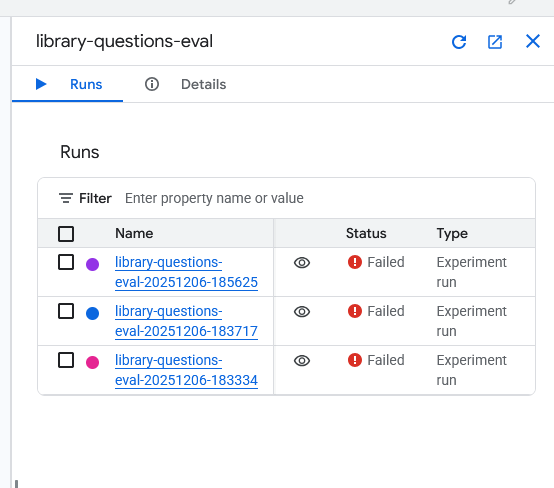



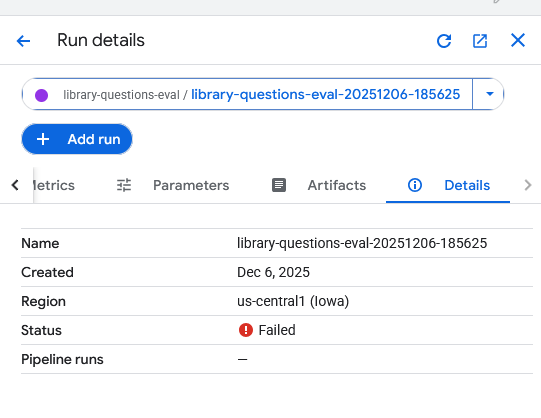